# Hand Gesture Recognition

### **Technique Summary:**

1. Feature Extraction Using AlexNet: Utilized AlexNet, a pre-trained convolutional neural network, to extract high-level features from your dataset. This step is crucial as it leverages the learned representations from a network trained on a large and diverse dataset.

2. ReLU Activation: After feature extraction, I applied the ReLU (Rectified Linear Unit) activation function. This was done post-convolution to introduce non-linearity into the network, allowing it to model complex relationships in the data without adding extra layers.

3. Training the Network:

    - Hyperparameter Tuning: I experimented with different learning rates and batch sizes to find the optimal settings for training your network.
        Conversion of Feature Tensors: To avoid inadvertent updates to AlexNet weights, I converted AlexNet feature tensors into numpy arrays and then back into PyTorch tensors.
        
    - Model Training: Trained newly configured network using the extracted features and tuned hyperparameters.

4. Comparative Analysis:
    
    - Testing and Reporting Accuracy: Reported the test accuracies of your models, both with and without transfer learning.
    
    - Performance Comparison: Provided a comparative analysis of the test results, demonstrating the effectiveness of transfer learning over a non-transfer learning approach by highlighting the substantial improvement in test accuracy.

5. Model Simplification: In the transfer learning scenario, I opted for a simpler model architecture compared to the more complex setup used in the non-transfer learning approach, focusing on efficiency and performance.


## 1. Problem Statement

**American Sign Language**

American Sign Language (ASL) is a complete, complex language that employs signs made by moving the
hands combined with facial expressions and postures of the body. It is the primary language of many
North Americans who are deaf and is one of several communication options used by people who are deaf or
hard-of-hearing.

The hand gestures representing English alphabet are shown below. This project focuses on classifying a subset
of these hand gesture images using convolutional neural networks. Specifically, given an image of a hand
showing one of the letters A-I, I want to detect which letter is being represented.

![alt text](https://www.disabled-world.com/pics/1/asl-alphabet.jpg)

## 2. Data Loading and Splitting

In [276]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
import os
import shutil
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
from torchvision.transforms import functional as TF
import torch.optim as optim

In [139]:
# Pre-defined parameters to load images
transformation = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [ ]:
# Splitting data to train val test
path_dir = '/content/drive/My Drive/1517hands'
target_dir = {
    "train": os.path.join(path_dir, "train"),
    "val": os.path.join(path_dir, "val"),
    "test": os.path.join(path_dir, "test")
}

# Create target directories if they do not exist
for dir_path in target_dir.values():
    os.makedirs(dir_path, exist_ok=True)

# Define helper function to split images
def split_images(class_dir, train_dir, val_dir, test_dir, train_limit, val_limit, test_limit=None):
    files = [f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))]

    # Group files by index
    grouped_files = {}
    for file in files:
        index = int(file.split('_')[0])
        if index not in grouped_files:
            grouped_files[index] = []
        grouped_files[index].append(file)

    # Initialize lists to hold file names for train, val, and test sets
    train_files, val_files, test_files = [], [], []

    # Split files based on index limits
    for index in sorted(grouped_files.keys()):
        if index <= train_limit:
            train_files.extend(grouped_files[index])
        elif index <= train_limit + val_limit:
            val_files.extend(grouped_files[index])
        else:
            if test_limit is None or index <= train_limit + val_limit + test_limit:
                test_files.extend(grouped_files[index])

    # Function to copy files to target directories within class subdirectories
    def copy_images(files, target_base_dir):
        class_subdir = os.path.join(target_base_dir, os.path.basename(class_dir))
        os.makedirs(class_subdir, exist_ok=True)
        for file in files:
            shutil.copy(os.path.join(class_dir, file), os.path.join(class_subdir, file))

    # Copy files to respective directories
    copy_images(train_files, train_dir)
    copy_images(val_files, val_dir)
    copy_images(test_files, test_dir)

# Iterate over each class directory and split the images
for class_name in 'ABCDEFGHI':
    class_dir = os.path.join(path_dir, class_name)
    # Set test_limit to 15 only for class 'I'
    test_limit = 15 if class_name == 'I' else 16
    split_images(
        class_dir,
        target_dir['train'],
        target_dir['val'],
        target_dir['test'],
        train_limit=70,
        val_limit=16,
        test_limit=test_limit
    )


In [34]:
# load each dataset and apply transformation
train_data = datasets.ImageFolder('/Users/marcia/Desktop/A2_middle/1517hands/train', transform=transformation)
val_data = datasets.ImageFolder('/Users/marcia/Desktop/A2_middle/1517hands/val', transform=transformation)
test_data = datasets.ImageFolder('/Users/marcia/Desktop/A2_middle/1517hands/test', transform=transformation)

# print out length of each dataset
print('Num training images: ', len(train_data))
print('Num validation images: ', len(val_data))
print('Num testing images: ', len(test_data))

Num training images:  1634
Num validation images:  401
Num testing images:  396


In [159]:
# Function to load dataset from a directory with transformations
def load_dataset(data_dir, transformation, bs = 32):
    dataset = datasets.ImageFolder(root=data_dir, transform=transformation)
    return torch.utils.data.DataLoader(dataset, batch_size=bs, shuffle=True)

# Load each dataset
train_loader = load_dataset('/Users/marcia/Desktop/A2_middle/1517hands/train', transformation)
val_loader = load_dataset('/Users/marcia/Desktop/A2_middle/1517hands/val', transformation)
test_loader = load_dataset('/Users/marcia/Desktop/A2_middle/1517hands/test', transformation)

# Check the shape of images
images, labels = next(iter(train_loader))
images.shape

torch.Size([32, 3, 224, 224])

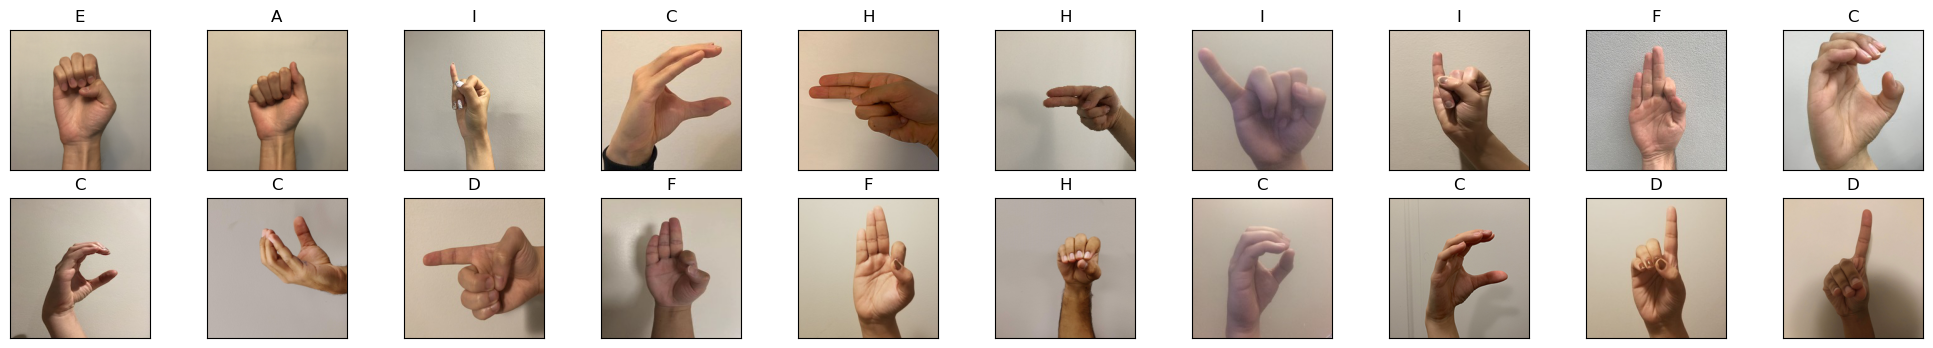

In [160]:
# Visualize some sample data
images = images.numpy() # convert images to numpy for display
classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])




#### **Explain splitting strategy**

---

The dataset is organized into folders labeled A to I, corresponding to different classes. Each image file is named following the format index_class_number, indicating the hand index, the class it belongs to, and the angle or variation number. To ensure that images of the same hand (identified by the index) are not distributed across the training and test datasets, which could lead to data leakage, I adopt an index-based splitting strategy.


For each class (A to I), I allocate the first 70 indexes to the training set, the subsequent 16 indexes to the validation set, and the final 16 indexes to the test set. For example, in class A, images named from 1_A_1 to 70_A_x (where x is the highest variation number for the 70th index) are designated for training. Images from 71_A_1 to 86_A_y (where y is the highest variation number for the 86th index) are allocated to validation, and the remaining images go to the test set. Within each of the train, validation, and test directories, images are organized into separate folders, each corresponding to its specific class.

This method results in varying numbers of images in each set due to the different counts of variations per index. Consequently, the sizes of the datasets are as follows: 1,634 images in training, 401 images in validation, and 396 images in testing. The variation in dataset sizes stems from the unequal distribution of variation images across the indexes. Additionally, it's important to note that not all groups have a complete set of indexes; some indexes may be missing in certain groups, which further contributes to the variation in the number of images across the datasets.

Here's a preliminary diagram illustrating the framework and rationale of splitting the data:

    /train  
        /A 
        /B 
        .  
        .  
        /I
    /val  
        /A 
        /B 
        .  
        .  
        /I
    /test  
        /A
        /B
        .  
        .  
        /I

## 3. Model Building and Sanity Checking

### 3.1 Convolutional Network

Build a convolutional neural network model that takes the (224x224 RGB) image as input, and predicts the gesture
letter.

In [141]:
# Convolutional Neural Network Architecture from Pre2A_CNN
class GestureCNN(nn.Module):
    def __init__(self):
        super(GestureCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 5, 5) #in_channels, out_chanels, kernel_size
        self.pool = nn.MaxPool2d(2, 2) #kernel_size, stride
        self.conv2 = nn.Conv2d(5, 10, 5) #in_channels, out_chanels, kernel_size
        self.fc1 = nn.Linear(53 * 53 * 10, 32)
        self.fc2 = nn.Linear(32, 9)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 53 * 53 * 10)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    print('Convolutional Neural Network Architecture Selected')

Convolutional Neural Network Architecture Selected




#### **Explain GestureCNN**

---

I selected a configuration for the GestureCNN network that comprises two convolutional layers, 2x2 max pooling, and two fully connected layers, with ReLU as the chosen activation function. 

**Convolutional Layers**

The first (conv1) takes an input with 3 channels (suitable for RGB images) and applies 5 filters with a kernel size of 5x5. This layer is instrumental in detecting basic visual features such as edges and textures. The second convolutional layer (conv2) further processes the output from conv1, using 10 filters to extract more complex features that are crucial for distinguishing between different hand gestures.

**Max Pooling** 

After each convolutional layer, a 2x2 max pooling operation is applied, reducing the spatial dimensions of the feature maps by half. This not only helps in reducing the computational load for subsequent layers but also aids in making the network more robust to small variations and translations in the input images.

**Fully Connected Layers**

The extracted and pooled features are then flattened into a single vector and passed through two fully connected layers. The first (fc1) transforms the high-dimensional feature vector into a 32-dimensional space, serving as a form of feature integration and dimensionality reduction. The second fully connected layer (fc2) acts as the output layer, mapping the 32-dimensional vector to 9 output nodes, each corresponding to a different hand gesture class.

**ReLU Activation** 

Throughout the network, the ReLU (Rectified Linear Unit) activation function is used to introduce non-linearity, enabling the network to learn complex patterns in the data. ReLU is preferred for its computational efficiency and effectiveness in mitigating the vanishing gradient problem, which is crucial for training deep neural networks.


**Dimensions**

**input img**

224 * 224 * 3

**Conv1**

input channel: 3

output channel: 5

kernal size: 5 * 5

output size: 220

**MaxPool**

output size: 110 * 110 * 5

**Conv2**

input channel: 5

output channel: 10

kernal size: 5 * 5

output size: 106 * 106 * 10

**MaxPool**

output size: 53 * 53 * 10




### 3.2 Training Code

In [ ]:
# function to calculate accuracy
def get_accuracy(model, data_loader):

    correct = 0
    total = 0
    for imgs, labels in data_loader:

        #############################################
        #To Enable GPU Usage
        if torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        #############################################

        output = model(imgs)

        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total


In [143]:
# Train NN
def get_model_name(name, batch_size, learning_rate, epoch):
    """
    Generate a name for the model to save based on the parameters.
    """
    return "{}_bs{}_lr{}_epoch{}.pth".format(name, batch_size, learning_rate, epoch)
def train(model, train_loader, val_loader, num_epochs=20, learning_rate=0.01, batch_size=32):
    print(f"Total {num_epochs} epochs, lr = {learning_rate}, bs = {batch_size}.")
    print(f"Start training {model.__class__.__name__} model...")
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

    use_cuda = torch.cuda.is_available()
    if use_cuda:
        model.cuda()
        print('CUDA available, training on GPU...')

    iters, losses, train_acc, val_acc = [], [], [], []

    start_time = time.time()
    for epoch in range(num_epochs):
        epoch_loss = 0  # Reset epoch loss for each epoch
        for imgs, labels in train_loader:
            if use_cuda:
                imgs, labels = imgs.cuda(), labels.cuda()

            optimizer.zero_grad()
            out = model(imgs)
            loss = criterion(out, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_epoch_loss = epoch_loss / len(train_loader)
        losses.append(avg_epoch_loss)
        iters.append(epoch)

        # Report and record loss and accuracy for each epoch
        train_accuracy = get_accuracy(model, train_loader)
        train_acc.append(train_accuracy)
        val_accuracy = get_accuracy(model, val_loader)
        val_acc.append(val_accuracy)
        # Report and save the model every 4 epochs and the last epoch
        if epoch % 4 == 0 or epoch == num_epochs - 1:
            print(f"Epoch {epoch}: Average Train Loss: {avg_epoch_loss:.4f}, "
                    f"Train Accuracy: {train_accuracy * 100:.2f}%, Validation Accuracy: {val_accuracy * 100:.2f}%")
            model_path = get_model_name(model.__class__.__name__, batch_size, learning_rate, epoch)
            torch.save(model.state_dict(), model_path)

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f'Finished Training in {elapsed_time:.2f} seconds')

    # Plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Accuracy Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

    # Print final accuracy
    print(f"Final Training Accuracy: {train_acc[-1] * 100:.2f}%")
    print(f"Final Validation Accuracy: {val_acc[-1] * 100:.2f}%")



#### **Explain Loss function and Optimizer**

---
The CrossEntropyLoss function is selected for its adept handling of multi-class classification challenges, a key requirement for scenarios like ours where each image must be classified into one of multiple categories, specifically classes A through I. By seamlessly integrating LogSoftmax and Negative Log Likelihood Loss (NLLLoss) into a unified operation, it offers an efficient solution for categorizing inputs into distinct classes. This loss function fine-tunes the model's confidence levels, ensuring that correct and confident predictions are encouraged while incorrect or ambiguous predictions are discouraged, thereby bolstering the model's predictive accuracy and reliability.

For optimization, the model employs Stochastic Gradient Descent (SGD) augmented with a momentum factor set to 0.9, chosen for SGD's well-established simplicity and proven efficacy in most of ML applications. The addition of momentum smooths the optimization path and accelerates convergence by incorporating information from previous updates, thereby enhancing the model's ability to escape local minima.

The training function's design allows for easy adjustments to key hyperparameters like batch size and learning rate, providing the flexibility needed to fine-tune the model for optimal performance.



*   **Explain the train function design**



In the training function's design, I've optimized for both computational efficiency and the ability to monitor model performance effectively. Accuracy is reported every 4 epoches (instead of reporting every epoch) to provide periodic feedback while minimizing computational overhead. This balance is crucial for managing large datasets or complex models and allows for timely adjustments to training parameters. The inclusion of the final epoch ensures a comprehensive evaluation of the model's performance.

### 3.3 Verify “Overfit” to a Small Dataset

One way to sanity check our neural network model and training code is to check whether the model is capable
of “overfitting” or “memorizing” a small dataset. A properly constructed CNN with correct training code
should be able to memorize the answers to a small number of images quickly.

This step shows that the model and training code is capable of memorizing the labels of this small data set.

In [39]:
def train_with_no_val(model, train_loader, num_epochs=20, learning_rate=0.01, batch_size=32):
    print(f"Total {num_epochs} epochs, lr = {learning_rate}, bs = {batch_size}.")
    print(f"Start training {model.__class__.__name__} model...")
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

    use_cuda = torch.cuda.is_available()
    if use_cuda:
        model.cuda()
        print('CUDA available, training on GPU...')

    iters, losses, train_acc, val_acc = [], [], [], []

    start_time = time.time()
    n = 0
    for epoch in range(num_epochs):
        epoch_loss = 0  # Reset epoch loss for each epoch
        for imgs, labels in train_loader:
            if use_cuda:
                imgs, labels = imgs.cuda(), labels.cuda()

            optimizer.zero_grad()
            out = model(imgs)
            loss = criterion(out, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_epoch_loss = epoch_loss / len(train_loader)
        losses.append(avg_epoch_loss)
        iters.append(epoch)
        train_accuracy = get_accuracy(model, train_loader)
        train_acc.append(train_accuracy)
        # store and print loss and accuracy every 10 epoch
        if n % 10 == 0 or n == num_epochs - 1:
            print(f"Epoch {epoch}: Train Accuracy: {train_accuracy * 100:.2f}% ")
            # Save the current model (checkpoint) to a file
            model_path = get_model_name(model.__class__.__name__, batch_size, learning_rate, epoch)
            torch.save(model.state_dict(), model_path)
        n +=1

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f'Finished Training in {elapsed_time:.2f} seconds')

    # Plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Accuracy Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

    # Print final accuracy
    print(f"Final Training Accuracy: {train_acc[-1] * 100:.2f}%")


Total 200 epochs, lr = 0.001, bs = 27.
Start training GestureCNN model...
Epoch 0: Train Accuracy: 11.11% 
Epoch 10: Train Accuracy: 14.81% 
Epoch 20: Train Accuracy: 11.11% 
Epoch 30: Train Accuracy: 11.11% 
Epoch 40: Train Accuracy: 18.52% 
Epoch 50: Train Accuracy: 22.22% 
Epoch 60: Train Accuracy: 29.63% 
Epoch 70: Train Accuracy: 48.15% 
Epoch 80: Train Accuracy: 70.37% 
Epoch 90: Train Accuracy: 88.89% 
Epoch 100: Train Accuracy: 100.00% 
Epoch 110: Train Accuracy: 100.00% 
Epoch 120: Train Accuracy: 100.00% 
Epoch 130: Train Accuracy: 100.00% 
Epoch 140: Train Accuracy: 100.00% 
Epoch 150: Train Accuracy: 100.00% 
Epoch 160: Train Accuracy: 100.00% 
Epoch 170: Train Accuracy: 100.00% 
Epoch 180: Train Accuracy: 100.00% 
Epoch 190: Train Accuracy: 100.00% 
Epoch 199: Train Accuracy: 100.00% 
Finished Training in 125.75 seconds


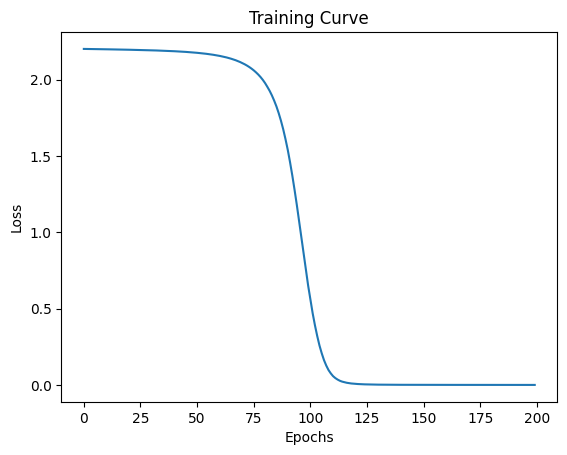

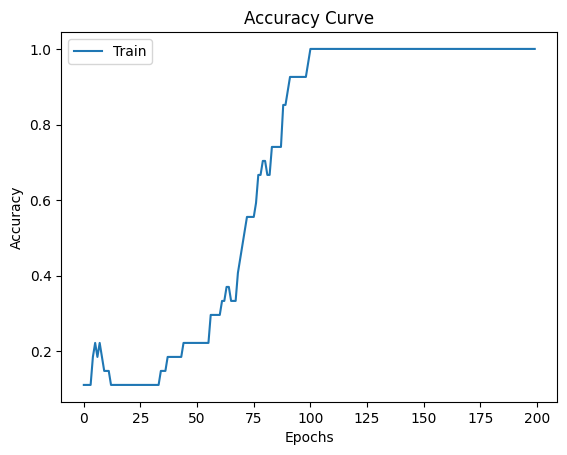

Final Training Accuracy: 100.00%


In [ ]:
# Load and train the small dataset
cnn_model = GestureCNN()
small_train_loader = load_dataset('/content/drive/My Drive/1517hands/smalldata', transformation, bs=27)
os.chdir('/content/drive/My Drive/small_model')
train_with_no_val(cnn_model, small_train_loader, num_epochs=200, learning_rate=0.008, batch_size=27)

**Analysis**


---


I have revised the training function for small dataset since we only want to examine whether it will overfit or not. There is no need to include the validation data and accuracy calculation in the function.

The training results demonstrate that the CNN has effectively memorized the small dataset, achieving 100% training accuracy early on and maintaining it throughout the process. The drop in training loss to zero confirms the network's capability to overfit, which is the desired outcome for this sanity check. The model's rapid convergence well within 200 iterations suggests that the architecture, training code, and hyperparameters are aptly chosen for the task. This successful overfitting to a small dataset validates the model's learning ability and the efficacy of the training setup.

## 4. Hyperparameter Search

### 4.1 Hyperparameter Tuning Strategy

Three hyperparameters that worth tuning.


In [ ]:
'''
(1) kernal size of CNN
    Influences feature scale sensitivity and computational efficiency;
    smaller kernels detect finer details, larger kernels capture broader features.

(2) learning rate
    Determines step size for updates;
    optimal rate ensures efficient convergence without overshooting or slow progress.

(3) batch size
    Balances between computational load and update frequency;
    larger sizes stabilize training, smaller sizes may enhance generalization.

'''

### 4.2 Tuning

In [207]:
# CNN with smaller kernal size
class GestureCNN2(nn.Module):
    def __init__(self):
        super(GestureCNN2, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, 5) #in_channels, out_chanels, kernel_size
        self.pool = nn.MaxPool2d(2, 2) #kernel_size, stride
        self.conv2 = nn.Conv2d(10, 15, 3) #in_channels, out_chanels, kernel_size
        self.conv3 = nn.Conv2d(15, 20, 1)
        self.fc1 = nn.Linear(27 * 27 * 20, 32)
        self.fc2 = nn.Linear(32, 9)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 27 * 27 * 20)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    print('Convolutional Neural Network 2 Architecture Selected')

Convolutional Neural Network 2 Architecture Selected


#### **Explain GestureCNN2**

---

The GestureCNN2 network is a convolutional neural network that consists of three convolutional layers, repeated 2x2 max pooling, and two fully connected layers, all utilizing the ReLU activation function for non-linearity.

**Convolutional Layers**

The network's initial layer, conv1, takes an input with 3 channels, for RGB images, and uses 10 filters with a kernel size of 5x5. This layer is pivotal for capturing basic visual elements like edges and textures with relatively large kernal size. Subsequently, conv2 advances the feature extraction process with 15 filters of kernal size 3x3, delving into more intricate patterns essential for differentiating hand gestures. The third layer, conv3, with its 1x1 kernel size, serves to integrate and refine the feature maps without altering their spatial dimensions, using 20 filters.

**Max Pooling**

Following each convolutional operation, a max pooling layer with a 2x2 window reduces the feature maps' dimensions by half, contributing to computational efficiency and increasing the model's robustness to minor input changes.

**Fully Connected Layers**

Post convolution and pooling, the network flattens the features into a one-dimensional vector to pass through the fully connected layers. fc1 acts as a bottleneck, compressing the data from the high-dimensional space of 27 * 27 * 20 into 32 features, facilitating complex feature relationships. The subsequent layer, fc2, maps these 32 features to 9 output nodes, corresponding to distinct hand gesture classifications.

**ReLU Activation**

The ReLU activation function is consistently applied after each convolutional layer and before the final classification layer, fostering the model's capacity to learn and model complex data relationships efficiently.

**Dimensions**

**Input Image**

224 * 224 * 3

**Conv1**

Input Channels: 3

Output Channels: 10

Kernel Size: 5 * 5

Output Size: 220 * 220 *10

**MaxPool**

Output Size: 110 * 110 * 10 

**Conv2**

Input Channels: 10

Output Channels: 15

Kernel Size: 3 * 3

Output Size: 108 * 108 * 15

**MaxPool**

Output Size: 54 * 54 * 15

**Conv3**

Input Channels: 15

Output Channels: 20

Kernel Size: 1 * 1

Output Size: 54 * 54 * 20

**MaxPool**

Output Size: 27 * 27 * 20


#### Model1 lr=0.008, bs=64

Total 30 epochs, lr = 0.008, bs = 64.
Start training GestureCNN2 model...
Epoch 0: Average Train Loss: 2.2003, Train Accuracy: 13.59%, Validation Accuracy: 12.22%
Epoch 4: Average Train Loss: 1.9717, Train Accuracy: 26.13%, Validation Accuracy: 27.68%
Epoch 8: Average Train Loss: 1.2328, Train Accuracy: 60.47%, Validation Accuracy: 60.85%
Epoch 12: Average Train Loss: 0.9803, Train Accuracy: 67.01%, Validation Accuracy: 60.35%
Epoch 16: Average Train Loss: 0.8261, Train Accuracy: 75.58%, Validation Accuracy: 70.32%
Epoch 20: Average Train Loss: 0.7676, Train Accuracy: 75.83%, Validation Accuracy: 66.33%
Epoch 24: Average Train Loss: 0.6475, Train Accuracy: 81.46%, Validation Accuracy: 71.57%
Epoch 28: Average Train Loss: 0.5186, Train Accuracy: 85.92%, Validation Accuracy: 69.33%
Epoch 29: Average Train Loss: 0.4738, Train Accuracy: 87.09%, Validation Accuracy: 74.81%
Finished Training in 600.11 seconds


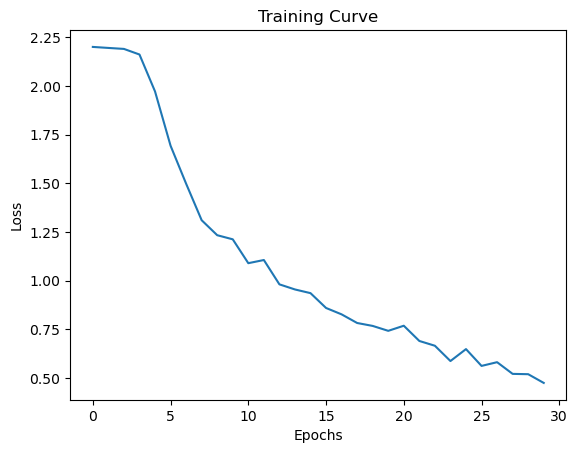

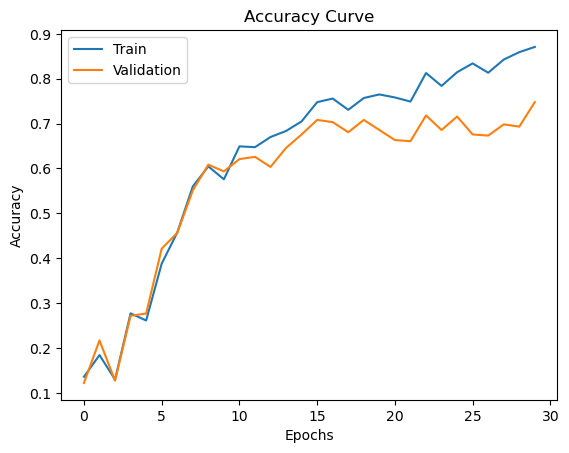

Final Training Accuracy: 87.09%
Final Validation Accuracy: 74.81%


In [208]:
# Train GNN2 with lr=0.008, bs=64
cnn2_model = GestureCNN2()
train_loader = load_dataset('/Users/marcia/Desktop/A2_middle/1517hands/train', transformation, bs=64)
val_loader = load_dataset('/Users/marcia/Desktop/A2_middle/1517hands/val', transformation, bs=64)
train(cnn2_model, train_loader, val_loader, num_epochs=30, learning_rate=0.008, batch_size=64)

#### Model2 lr=0.008, bs=32

Total 30 epochs, lr = 0.008, bs = 32.
Start training GestureCNN2 model...
Epoch 0: Average Train Loss: 2.2025, Train Accuracy: 11.20%, Validation Accuracy: 11.22%
Epoch 4: Average Train Loss: 2.1854, Train Accuracy: 21.60%, Validation Accuracy: 21.95%
Epoch 8: Average Train Loss: 1.2957, Train Accuracy: 56.98%, Validation Accuracy: 57.36%
Epoch 12: Average Train Loss: 0.9220, Train Accuracy: 72.58%, Validation Accuracy: 66.58%
Epoch 16: Average Train Loss: 0.6419, Train Accuracy: 76.50%, Validation Accuracy: 60.35%
Epoch 20: Average Train Loss: 0.6700, Train Accuracy: 88.19%, Validation Accuracy: 72.82%
Epoch 24: Average Train Loss: 0.2987, Train Accuracy: 93.76%, Validation Accuracy: 69.08%
Epoch 28: Average Train Loss: 0.2238, Train Accuracy: 94.31%, Validation Accuracy: 67.58%
Epoch 29: Average Train Loss: 0.1752, Train Accuracy: 92.66%, Validation Accuracy: 62.84%
Finished Training in 634.19 seconds


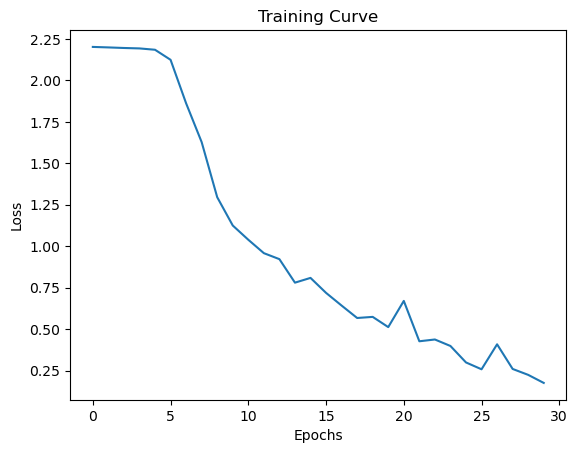

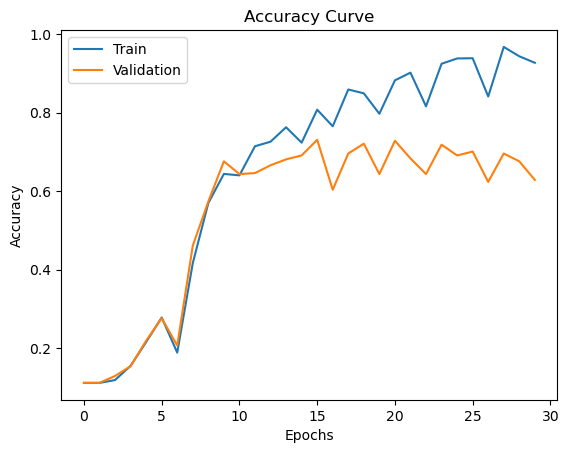

Final Training Accuracy: 92.66%
Final Validation Accuracy: 62.84%


In [216]:
# Train GNN2 with lr=0.008, bs=32
cnn2_model = GestureCNN2()
train_loader = load_dataset('/Users/marcia/Desktop/A2_middle/1517hands/train', transformation, bs=32)
val_loader = load_dataset('/Users/marcia/Desktop/A2_middle/1517hands/val', transformation, bs=32)
train(cnn2_model, train_loader, val_loader, num_epochs=30, learning_rate=0.008, batch_size=32)

#### Model3 lr=0.009, bs=16

Total 30 epochs, lr = 0.009, bs = 16.
Start training GestureCNN2 model...
Epoch 0: Average Train Loss: 2.2008, Train Accuracy: 20.93%, Validation Accuracy: 17.96%
Epoch 4: Average Train Loss: 1.0986, Train Accuracy: 69.40%, Validation Accuracy: 64.59%
Epoch 8: Average Train Loss: 0.8632, Train Accuracy: 74.17%, Validation Accuracy: 60.35%
Epoch 12: Average Train Loss: 0.4619, Train Accuracy: 85.56%, Validation Accuracy: 67.33%
Epoch 16: Average Train Loss: 0.2010, Train Accuracy: 94.12%, Validation Accuracy: 69.08%
Epoch 20: Average Train Loss: 0.3952, Train Accuracy: 92.84%, Validation Accuracy: 63.09%
Epoch 24: Average Train Loss: 0.0519, Train Accuracy: 99.27%, Validation Accuracy: 71.32%
Epoch 28: Average Train Loss: 0.0810, Train Accuracy: 99.20%, Validation Accuracy: 66.83%
Epoch 29: Average Train Loss: 0.0641, Train Accuracy: 98.71%, Validation Accuracy: 65.34%
Finished Training in 702.31 seconds


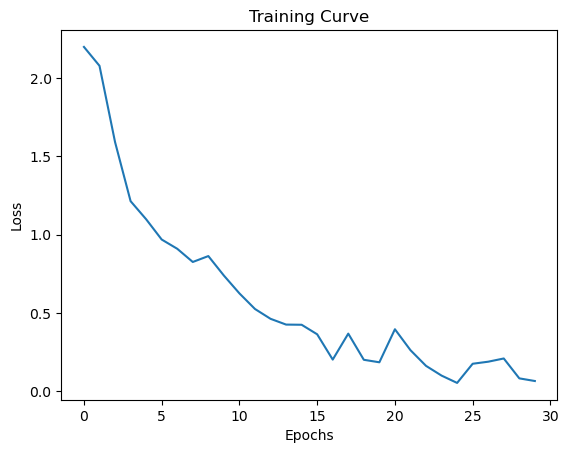

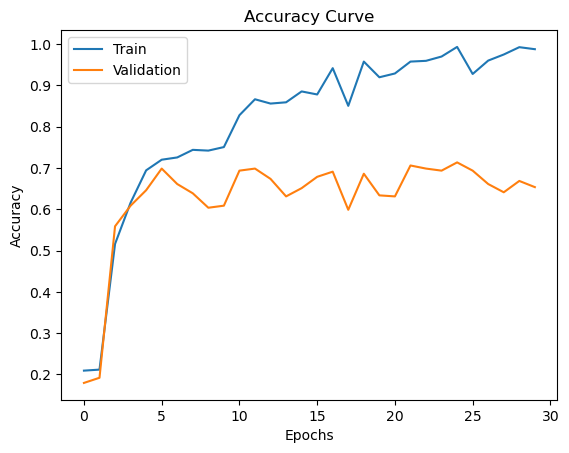

Final Training Accuracy: 98.71%
Final Validation Accuracy: 65.34%


In [223]:
# Train GNN2 with lr=0.009, bs=16
cnn2_model = GestureCNN2()
train_loader = load_dataset('/Users/marcia/Desktop/A2_middle/1517hands/train', transformation, bs=16)
val_loader = load_dataset('/Users/marcia/Desktop/A2_middle/1517hands/val', transformation, bs=16)
train(cnn2_model, train_loader, val_loader, num_epochs=30, learning_rate=0.009, batch_size=16)

#### Model4 lr=0.007, bs=64

Total 30 epochs, lr = 0.007, bs = 64.
Start training GestureCNN2 model...
Epoch 0: Average Train Loss: 2.1996, Train Accuracy: 11.20%, Validation Accuracy: 11.22%
Epoch 4: Average Train Loss: 2.1932, Train Accuracy: 20.13%, Validation Accuracy: 18.20%
Epoch 8: Average Train Loss: 1.6457, Train Accuracy: 30.05%, Validation Accuracy: 29.18%
Epoch 12: Average Train Loss: 1.0688, Train Accuracy: 66.34%, Validation Accuracy: 66.83%
Epoch 16: Average Train Loss: 0.8289, Train Accuracy: 66.83%, Validation Accuracy: 62.09%
Epoch 20: Average Train Loss: 0.7339, Train Accuracy: 73.07%, Validation Accuracy: 71.07%
Epoch 24: Average Train Loss: 0.5969, Train Accuracy: 79.56%, Validation Accuracy: 67.83%
Epoch 28: Average Train Loss: 0.5148, Train Accuracy: 83.48%, Validation Accuracy: 66.58%
Epoch 29: Average Train Loss: 0.5271, Train Accuracy: 85.01%, Validation Accuracy: 72.57%
Finished Training in 607.97 seconds


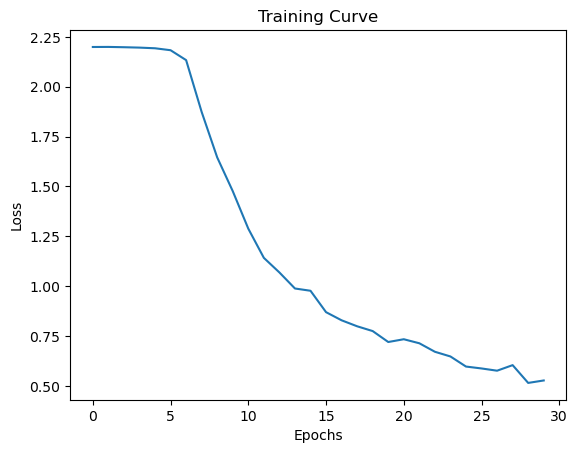

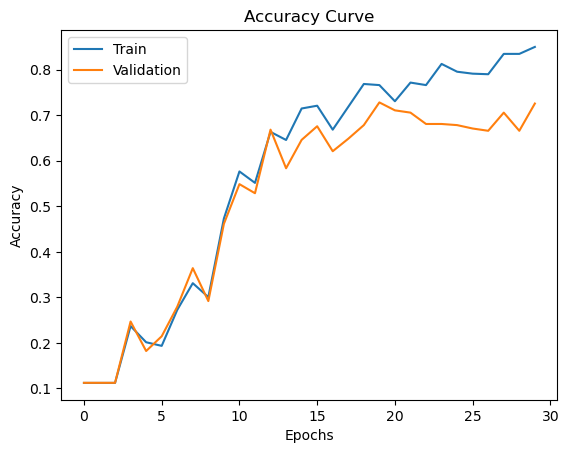

Final Training Accuracy: 85.01%
Final Validation Accuracy: 72.57%


In [224]:
# Train GNN2 with lr=0.007, bs=256
cnn2_model = GestureCNN2()
train_loader = load_dataset('/Users/marcia/Desktop/A2_middle/1517hands/train', transformation, bs=64)
val_loader = load_dataset('/Users/marcia/Desktop/A2_middle/1517hands/val', transformation, bs=64)
train(cnn2_model, train_loader, val_loader, num_epochs=30, learning_rate=0.007, batch_size=64)

### 4.3 Discussion (Best Model Justification)

The first model with a learning rate of 0.008, a batch size of 64, and running for 30 epochs has proven to be the best among those tested. It consistently delivers the highest validation accuracy. Notably, the model reaches its peak validation accuracy at the 29th epoch, which justifies the decision to train it for a total of 30 epochs, allowing the model ample opportunity to achieve and sustain its peak performance.

The chosen batch size of 64 is a deliberate compromise. As can be seen in parameter search, a smaller batch size, such as bs=16, can slow down the training process and introduce too much variance in the weight updates, while a larger batch size can gloss over important nuances in the data, potentially leading to suboptimal learning outcomes. The learning rate of 0.008 strikes the right balance, being neither too aggressive, which could cause the model to overshoot optimal solutions, nor too cautious, which might slow down the learning process unnecessarily.

The training trajectory, as illustrated in the graph, shows a swift phase of initial learning, succeeded by consistent and gradual improvement. This is evidenced by the steady decrease in training loss and the corresponding increase in training and validation accuracy. The model demonstrates a commendable balance between bias and variance, as indicated by a reasonable gap between training and validation accuracy, which is a positive indicator of its ability to generalize well to unseen data. These results, coupled with the well-calibrated learning dynamics, underscore the model's superiority within the evaluated cohort.

### 4.4 Test Accuracy on Best Model

In [229]:
# run best model on test dataset
best_model = GestureCNN2()
best_path = 'GestureCNN2_bs64_lr0.008_epoch29.pth'
best_model.load_state_dict(torch.load(best_path))
if torch.cuda.is_available():
    best_model.cuda()
test_loader = load_dataset('/Users/marcia/Desktop/A2_middle/1517hands/test', transformation, bs=64)
accuracy_test = get_accuracy(best_model, test_loader)
print(f"Test Accuracy for 'GestureCNN2_bs64_lr0.008_epoch29' is: {accuracy_test:.2%}")

Test Accuracy for 'GestureCNN2_bs128_lr0.007_epoch24' is: 71.46%


## 5. Transfer Learning
Use Transfer Learning to extract features from the hand gesture images. Then, train a smaller network to use these features as input and classify the hand gestures.

### 5.1 AlexNet
Here is the code to load the AlexNet network, with pretrained weights. When you first run the code, PyTorch
will download the pretrained weights from the internet.

In [ ]:
import torchvision.models
alexnet = torchvision.models.alexnet(pretrained=True)

In [43]:
alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

The alexnet model is split up into two components: *alexnet.features* and *alexnet.classifier*. The
first neural network component, *alexnet.features*, is used to compute convolutional features, which are
taken as input in *alexnet.classifier*.

The neural network alexnet.features expects an image tensor of shape Nx3x224x224 as input and it will
output a tensor of shape Nx256x6x6 . (N = batch size).

In [44]:
# function to extract feature
def compute_alexnet_features(dataloader):
    features = []
    labels = []
    for inputs, label in dataloader:
        with torch.no_grad(): 
            alexnet.eval()
            output = alexnet.features(inputs)  # Compute the features
            features.append(output)
            labels.append(label)
    return torch.cat(features), torch.cat(labels)


In [45]:
train_loader = load_dataset('/Users/marcia/Desktop/hands/train', transformation, bs=1)
val_loader = load_dataset('/Users/marcia/Desktop/hands/val', transformation, bs=1)
test_loader = load_dataset('/Users/marcia/Desktop/hands/test', transformation, bs=1)
train_features, train_labels = compute_alexnet_features(train_loader)
val_features, val_labels = compute_alexnet_features(val_loader)
test_features, test_labels = compute_alexnet_features(test_loader)

print(train_features.size(), train_labels.size())
print(val_features.size(), val_labels.size())
print(test_features.size(), test_labels.size())


torch.Size([1634, 256, 6, 6]) torch.Size([1634])
torch.Size([401, 256, 6, 6]) torch.Size([401])
torch.Size([396, 256, 6, 6]) torch.Size([396])


**Save the computed features**

In [46]:
# Save features
print('Saving features and labels....')
torch.save(train_features, 'train_features.pt')
torch.save(val_features, 'val_features.pt')
torch.save(test_features, 'test_features.pt')
torch.save(train_labels, 'train_labels.pt')
torch.save(val_labels, 'val_labels.pt')
torch.save(test_labels, 'test_labels.pt')
print('Done!')

Saving features and labels....
Done!


### 5.2 CNN for Transfer Learning
Build a convolutional neural network model that takes as input these AlexNet features, and makes a
prediction.

In [47]:
class Classifier_CNN(nn.Module):
    def __init__(self):
        super(Classifier_CNN, self).__init__()
        self.name = "large_cnn_alex"
        self.conv1 = nn.Conv2d(256, 16, 3, padding=1) #in_channels, out_chanels, kernel_size
        self.fc = nn.Linear(6 * 6 * 16, 9)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = x.view(-1, 6 * 6 * 16)
        x = self.fc(x)
        return x

In [48]:
#  Calling model...
model = Classifier_CNN()
train_outputs = model(train_features)
val_outputs = model(val_features)
test_outputs = model(test_features)

# Applying softmax to obtain probability
train_prob = F.softmax(train_outputs, dim=1)
val_prob = F.softmax(val_outputs, dim=1)
test_prob = F.softmax(test_outputs, dim=1)

In [49]:
train_prob

tensor([[0.1083, 0.0960, 0.1237,  ..., 0.1129, 0.1128, 0.1280],
        [0.1280, 0.0858, 0.1189,  ..., 0.1112, 0.1171, 0.1274],
        [0.1205, 0.0837, 0.1336,  ..., 0.1262, 0.0965, 0.1448],
        ...,
        [0.1195, 0.0890, 0.1272,  ..., 0.1364, 0.1259, 0.1018],
        [0.1254, 0.1003, 0.1246,  ..., 0.1017, 0.1126, 0.1309],
        [0.1381, 0.0970, 0.1254,  ..., 0.1332, 0.1090, 0.1138]],
       grad_fn=<SoftmaxBackward0>)


#### **Explain Classifier_CNN**

---

For the Classifier_CNN network, since I am taking features extracted in AlexNet as input, I design a minimalistic yet effective structure, consisting of a single convolutional layer followed by a fully connected layer, with ReLU as the activation function.

**Convolutional Layer**

A single convolutional layer (conv1),  tailored to refine 256-channel inputs derived from AlexNet, utilizing 16 3x3 filters with padding to preserve spatial dimensions. The absence of a pooling layer is deliberate, as AlexNet's preprocessing already reduces spatial dimensions, and maintaining the resolution of the 6x6 feature maps is crucial for the detailed classification of hand gestures. 

**Fully Connected Layer**

The network transitions directly from the convolutional layer to a fully connected layer (fc) without an intervening pooling layer. The output of conv1 is reshaped into a 1D vector that retains the full detail of the 6x6x16 feature representation. The fc layer then serves as a classifier, transforming these detailed features into 9 distinct outputs, each representing a unique class, likely corresponding to specific hand gestures.

**ReLU Activation**

A ReLU activation function is strategically applied post-convolution to inject non-linearity into the network, enabling the single convolutional layer to learn and model complex relationships within the high-level features passed down from AlexNet. This choice aids in capturing the nuances necessary for accurate classification without complicating the model with additional layers.

**Dimensions**

**input dim**

6 * 6 * 256

**Conv1**

input channel: 256

output channel: 16

kernal size: 3 * 3

padding = 1

output size: 6 * 6 * 16


### 5.3 Training
Train new network, including hyperparameter tuning. 

In [50]:
def train_feat(model, train_feature_loader, val_feature_loader, num_epochs=20, learning_rate=0.01, batch_size=32):
    print(f"Total {num_epochs} epochs, lr = {learning_rate}, bs = {batch_size}.")
    print(f"Start training {model.__class__.__name__} model...")
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

    use_cuda = torch.cuda.is_available()
    if use_cuda:
        model.cuda()
        print('CUDA available, training on GPU...')

    losses, train_accs, val_accs = [], [], []

    start_time = time.time()
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        for features, labels in train_feature_loader:
            if use_cuda:
                features, labels = features.cuda(), labels.cuda()

            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        # Calculate average loss and train accuracy
        avg_epoch_loss = epoch_loss / len(train_feature_loader)
        train_accuracy = get_accuracy(model, train_feature_loader)
        losses.append(avg_epoch_loss)
        train_accs.append(train_accuracy)

        val_accuracy = get_accuracy(model, val_feature_loader)
        val_accs.append(val_accuracy)
        print(f"Epoch {epoch}: Train Loss: {avg_epoch_loss:.4f}, Train Acc: {train_accuracy * 100:.2f}%, Val Acc: {val_accuracy * 100:.2f}%")
        model_path = get_model_name(model.__class__.__name__, batch_size, learning_rate, epoch)
        torch.save(model.state_dict(), model_path)

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f'Finished Training in {elapsed_time:.2f} seconds')

    # Plotting
    plt.title("Training Curve")
    plt.plot(losses, label="Train Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    plt.title("Accuracy Curve")
    plt.plot(train_accs, label="Train Acc")
    plt.plot(val_accs, label="Val Acc")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

    print(f"Final Training Accuracy: {train_accs[-1] * 100:.2f}%")
    print(f"Final Validation Accuracy: {val_accs[-1] * 100:.2f}%")


#### Train Features (lr=0.005, bs256)

Total 20 epochs, lr = 0.005, bs = 256.
Start training Classifier_CNN model...


Epoch 0: Train Loss: 2.1579, Train Acc: 44.37%, Val Acc: 44.39%
Epoch 1: Train Loss: 1.8146, Train Acc: 68.85%, Val Acc: 63.84%
Epoch 2: Train Loss: 1.2561, Train Acc: 74.60%, Val Acc: 75.56%
Epoch 3: Train Loss: 0.8383, Train Acc: 79.80%, Val Acc: 80.55%
Epoch 4: Train Loss: 0.6453, Train Acc: 83.41%, Val Acc: 84.54%
Epoch 5: Train Loss: 0.5288, Train Acc: 83.29%, Val Acc: 87.53%
Epoch 6: Train Loss: 0.4524, Train Acc: 89.35%, Val Acc: 87.53%
Epoch 7: Train Loss: 0.3686, Train Acc: 89.60%, Val Acc: 86.03%
Epoch 8: Train Loss: 0.3371, Train Acc: 92.11%, Val Acc: 88.03%
Epoch 9: Train Loss: 0.3017, Train Acc: 92.66%, Val Acc: 87.03%
Epoch 10: Train Loss: 0.2815, Train Acc: 91.92%, Val Acc: 89.03%
Epoch 11: Train Loss: 0.2636, Train Acc: 93.82%, Val Acc: 89.53%
Epoch 12: Train Loss: 0.2376, Train Acc: 94.12%, Val Acc: 89.28%
Epoch 13: Train Loss: 0.2257, Train Acc: 94.86%, Val Acc: 89.53%
Epoch 14: Train Loss: 0.2147, Train Acc: 94.31%, Val Acc: 89.78%
Epoch 15: Train Loss: 0.2002, Train

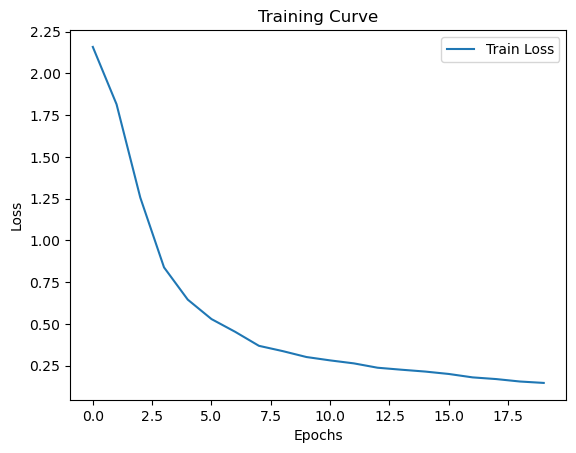

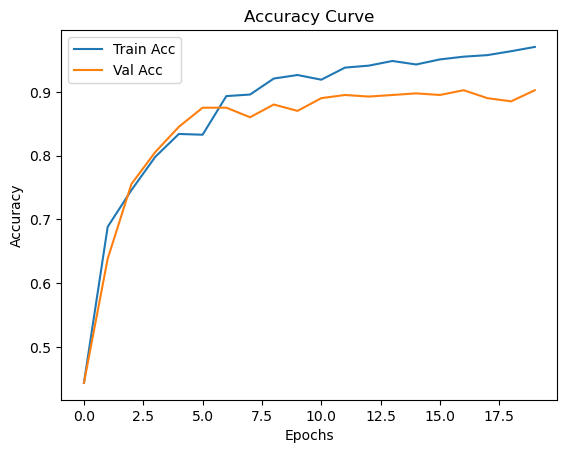

Final Training Accuracy: 97.06%
Final Validation Accuracy: 90.27%


In [92]:
# Load precomputed features and convert them
train_features = torch.from_numpy(torch.load('train_features.pt').detach().numpy())
val_features = torch.from_numpy(torch.load('val_features.pt').detach().numpy())
test_features = torch.from_numpy(torch.load('test_features.pt').detach().numpy())

# Create TensorDatasets
train_dataset = TensorDataset(train_features, train_labels)
val_dataset = TensorDataset(val_features, val_labels)
test_dataset = TensorDataset(test_features, test_labels)

# Create DataLoaders
batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Initialize model and call the train function
model = Classifier_CNN()
train_feat(model, train_loader, val_loader, num_epochs=20, learning_rate=0.005, batch_size=256)

### 5.4 Test Accuracy Report & Comparison
Report the test accuracy of the best model

In [262]:
# run best model on test dataset
best_model = Classifier_CNN()
best_path = 'Classifier_CNN_bs256_lr0.005_epoch19.pth'
best_model.load_state_dict(torch.load(best_path))
if torch.cuda.is_available():
    best_model.cuda()
test_features = torch.from_numpy(torch.load('test_features.pt').detach().numpy())
test_dataset = TensorDataset(test_features, test_labels)
test_loader = DataLoader(test_dataset, batch_size=256)
accuracy_test = get_accuracy(best_model, test_loader)
print(f"Test Accuracy for 'Classifier_CNN_bs256_lr0.005_epoch19' is: {accuracy_test:.2%}")

Test Accuracy for 'Classifier_CNN_bs256_lr0.005_epoch19' is: 92.17%


#### **Compare the best model with & without transfer learning**

---

The test accuracy of the model utilizing transfer learning, 'Classifier_CNN_bs256_lr0.005_epoch19', is significantly higher at 92.17% compared to the model developed without transfer learning, 'GestureCNN2_bs128_lr0.007_epoch24', which achieved a test accuracy of 71.46%. This substantial difference of approximately 20.71 percentage points underscores the effectiveness of transfer learning in enhancing model performance.

It is noteworthy that the architecture of the model designed for Part 3, which does not incorporate transfer learning, is more complex with three convolutional layers and two fully connected layers. In contrast, the Part 4 model, which employs transfer learning, has a simpler structure consisting of just one convolutional layer and one fully connected layer. Despite its simpler architecture, the transfer learning model achieves superior performance.

This contrast in complexity and performance further emphasizes the benefits of transfer learning. By utilizing a pre-trained network, the model for Part 4 likely capitalized on the rich feature representations learned from extensive prior training on a large dataset, resulting in enhanced generalization and higher test accuracy. This is a clear demonstration of how transfer learning can not only improve model accuracy but also reduce the need for more complex architectures, streamlining the model design without compromising on performance.


## 6. Testing on New Data


### 6.1 Load and Preprocess the new images

In [197]:
# load the new data
newdata_dataloader = load_dataset("/Users/marcia/Desktop/A2_middle/newdata", transformation, bs=1)
new_features, new_labels = compute_alexnet_features(newdata_dataloader)
print(f"New features: {new_features.shape}, New labels: {new_labels.shape}")
torch.save(new_features, 'new_features.pt')
torch.save(new_labels, 'new_labels.pt')


New features: torch.Size([27, 256, 6, 6]), New labels: torch.Size([27])


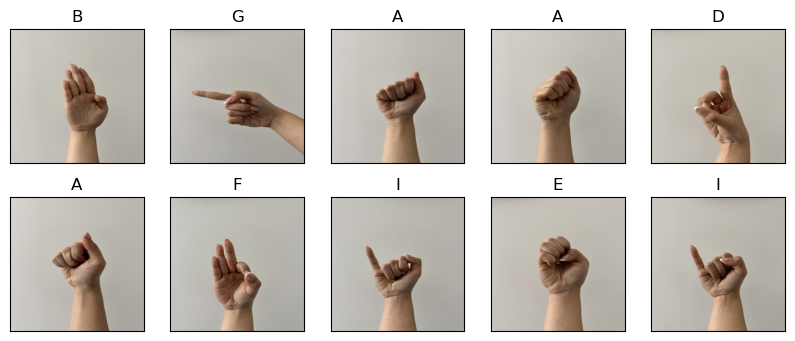

In [269]:
# Visualize some data
newdata_loader = load_dataset("/Users/marcia/Desktop/A2_middle/newdata", transformation)
images, labels = next(iter(newdata_loader))
images.shape
images = images.numpy() # convert images to numpy for display
classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(10, 4))
for idx in np.arange(10):
    ax = fig.add_subplot(2, 5, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

### 6.2 Implementing the best model


In [332]:
# Running best CNN model on new dataset
best_model = GestureCNN2()
best_path = 'GestureCNN2_bs64_lr0.008_epoch29.pth'
best_model.load_state_dict(torch.load(best_path))
if torch.cuda.is_available():
    best_model.cuda()
new_loader = load_dataset('/Users/marcia/Desktop/A2_middle/newdata', transformation, bs=64)
accuracy_new_p3 = get_accuracy(best_model, new_loader)
print(f"Accuracy on New dataset for 'GestureCNN2_bs64_lr0.008_epoch29' is: {accuracy_new_p3:.2%}")


Accuracy on New dataset for 'GestureCNN2_bs64_lr0.008_epoch29' is: 66.67%


In [294]:
def get_accuracy(model, data_loader):

    correct = 0
    total = 0
    for imgs, labels in data_loader:

        #############################################
        #To Enable GPU Usage
        if torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        #############################################

        output = model(imgs)

        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total


In [304]:
# accuracy for each class (CNN Model)
best_model = GestureCNN2()
best_path = 'GestureCNN2_bs64_lr0.008_epoch29.pth'
best_model.load_state_dict(torch.load(best_path))
new_loader = load_dataset('/Users/marcia/Desktop/A2_middle/newdata', transformation, bs=64)
correct = [0,0,0,0,0,0,0,0,0]
total = [0,0,0,0,0,0,0,0,0]
for imgs, labels in new_loader:    
    output = best_model(imgs)
    pred = output.max(1, keepdim=True)[1]
    for i, label in enumerate(labels):
        correct_label = label.item()
        correct[correct_label] += pred[i].eq(label.view_as(pred[i])).sum().item()
        total[correct_label] += 1
for i in range(9):
    print(f"Accuracy of class {chr(65 + i)}:", round(correct[i] / total[i], 2) if total[i] else 0)

Accuracy of class A: 1.0
Accuracy of class B: 0.0
Accuracy of class C: 0.33
Accuracy of class D: 1.0
Accuracy of class E: 0.67
Accuracy of class F: 0.67
Accuracy of class G: 1.0
Accuracy of class H: 1.0
Accuracy of class I: 0.33


In [329]:
# Runing best model from transfer learning on new dataset
# Load precomputed features and convert them
new_features = torch.from_numpy(torch.load('new_features.pt').detach().numpy())
new_labels = torch.from_numpy(torch.load('new_labels.pt').detach().numpy())

# Create TensorDatasets and Loader
new_dataset = TensorDataset(new_features, new_labels)
new_loader = DataLoader(new_dataset, batch_size=1)

# run best model on new dataset
best_model = Classifier_CNN()
best_path = 'Classifier_CNN_bs256_lr0.005_epoch19.pth'
best_model.load_state_dict(torch.load(best_path))
if torch.cuda.is_available():
    best_model.cuda()
accuracy_new_p4 = get_accuracy(best_model, new_loader)
print(f"Accuracy on New Dataset for 'Classifier_CNN_bs256_lr0.005_epoch19' Model is: {accuracy_new_p4:.2%}")

Accuracy on New Dataset for 'Classifier_CNN_bs256_lr0.005_epoch19' Model is: 88.89%


In [330]:
# accuracy for each class (transfer learning))
new_features = torch.from_numpy(torch.load('new_features.pt').detach().numpy())
new_labels = torch.from_numpy(torch.load('new_labels.pt').detach().numpy())

# Create TensorDatasets and Loader
new_dataset = TensorDataset(new_features, new_labels)
new_loader = DataLoader(new_dataset, batch_size=1)

# run best model on new dataset
best_model = Classifier_CNN()
best_path = 'Classifier_CNN_bs256_lr0.005_epoch19.pth'
best_model.load_state_dict(torch.load(best_path))
correct = [0,0,0,0,0,0,0,0,0]
total = [0,0,0,0,0,0,0,0,0]
for imgs, labels in new_loader:    
    output = best_model(imgs)
    pred = output.max(1, keepdim=True)[1]  # Get the index of the max log-probability

    for i, label in enumerate(labels):
        correct_label = label.item()
        correct[correct_label] += pred[i].eq(label.view_as(pred[i])).sum().item()
        total[correct_label] += 1

for i in range(9):  # Assuming 9 classes labeled from 0 to 8
    print(f"Accuracy of class {chr(65 + i)}:", round(correct[i] / total[i], 2) if total[i] else 0)

Accuracy of class A: 0.67
Accuracy of class B: 0.67
Accuracy of class C: 1.0
Accuracy of class D: 1.0
Accuracy of class E: 1.0
Accuracy of class F: 1.0
Accuracy of class G: 0.67
Accuracy of class H: 1.0
Accuracy of class I: 1.0


In [333]:
# overall accuracy report
original_accuracy_part3 = 0.7146 
original_accuracy_part4 = 0.9217  

# New accuracies from the provided code snippets
accuracy_new_part3 = round(accuracy_new_p3, 4)
accuracy_new_part4 = round(accuracy_new_p4, 4)

# Create a pandas DataFrame
results_df = pd.DataFrame({
    'Model': ['GestureCNN2 (Part 3)', 'Classifier_CNN (Part 4)'],
    'Original Test Accuracy': [original_accuracy_part3, original_accuracy_part4],
    'New Dataset Accuracy': [accuracy_new_part3, accuracy_new_part4]
})

results_df

,Model,Original Test Accuracy,New Dataset Accuracy
0,GestureCNN2 (Part 3),0.7146,0.6667
1,Classifier_CNN (Part 4),0.9217,0.8889


### 6.3 Analysis

Starting with the model from Part 4, which employs transfer learning from AlexNet, the training process reveals a rapid improvement in both training and validation accuracy over the epochs. This model achieved a final training accuracy of 97.06% and a validation accuracy of 90.27%, suggesting a strong learning capability and a good fit to the data without significant overfitting. The high test accuracy of 92.17% on the original dataset and 88.89% on the new dataset indicates that the transfer learning approach has effectively generalized the features from AlexNet to the hand gesture recognition task. The model's performance on the new data, my own hand gestures, further emphasizes its potential for real-world applications.

In contrast, the model from Part 3, constructed without the benefits of transfer learning, shows a final training accuracy of 87.09% and a validation accuracy of 74.81%. This suggests that while the model has learned the training data reasonably well, it is not as effective at generalizing this knowledge to unseen data, as reflected by a lower validation accuracy. The test accuracy of 71.46% on the original dataset and 66.67% on the new dataset with my hand gestures also points to a performance gap compared to the transfer learning model.

It is particularly striking that the model from Part 3, which was developed without the advantages of transfer learning, incorporates a more complicated architecture with three convolutional layers and two fully connected layers. Conversely, the Part 4 model, benefiting from transfer learning, boasts a streamlined design featuring merely one convolutional layer and one fully connected layer. Despite this apparent simplicity, the transfer learning model outperforms its counterpart. This disparity in performance can largely be attributed to the transfer learning model's utilization of pre-existing feature representations, which act as an advanced starting point for the task of hand gesture recognition, allowing for high accuracy with a more straightforward network structure. Conversely, the model without transfer learning requires a more intricate architecture to develop these feature representations independently, a process that can be both arduous and less efficient.

However, it's important to note that the training, validation, and testing datasets contain some misclassified images due to human labeling errors. These inaccuracies, though minor in proportion, have significant implications for model performance. They can mislead the model during the learning process, leading to incorrect associations that might compromise its ability to accurately generalize to new, correctly labeled data. Additionally, these misclassifications can affect the evaluation of the model's accuracy, potentially leading to overestimated or underestimated performance metrics. So, if my models can be trained and tested on a more accurate dataset in the future, its performance is expected to improve significantly.

Moreover, there is reason to believe that enhancing the complexity of the transfer learning model—with additional convolutional and fully connected layers—could potentially lead to even more impressive results. By doing so, the model might capture a broader and more nuanced range of features, further improving its ability to accurately recognize various hand gestures. However, it's essential to balance model complexity with the risk of overfitting, ensuring that any increase in depth truly contributes to the model's generalization capabilities.

Regarding real-world deployment, a more sophisticated model with transfer learning will be the best to be applied due to its training efficiency and its superior performance on unseen data. To further improve its performance and ensure it's ready for deployment, the following steps could be undertaken:

- Data Augmentation: Implement more aggressive data augmentation strategies to simulate a variety of real-world conditions, such as different hand sizes, lighting changes, and backgrounds.

- Continuous Learning: Implement a system where the model can continue learning from new data it encounters after deployment, possibly through online learning or periodic retraining.

- User Feedback Loop: Create a mechanism to gather user feedback on the model's predictions to identify and correct misclassifications.

- Real-time Testing: Conduct extensive real-time testing to ensure the model can handle the latency and computational constraints of a live environment.

# Challenging Exploration 

1. Test best models (with or without transfer learning) on hand gestures images with backgrounds that are not clean and smooth.
2. Generated additional data by performing data augmentation to replace the clean, smooth backgrounds with backgrounds with different textures. 
3. Improve on data augmentation by applying scale, rotation, and translation transformations on different backgrounds.
4. Compare the performance of best CNN models (with and without transfoer learning) trained with data augmentation to the results in 1. where I did not train on images with data augmentation.
5. Implement one of many region proposal tools to detect hand gestures in image frames and put a bounding box around the region with the highest confidence. 
6. Create a short video demonstration how I can use hand gesture recognition model to communicate a message using hand gestures.

### Step 1: compare the  performance of best CNN(without and with transfer learning )
images: https://doi.org/10.25540/AWJS-GMJB
reference: https://www.mdpi.com/2076-3417/12/14/7303
dataset in folder: dataset

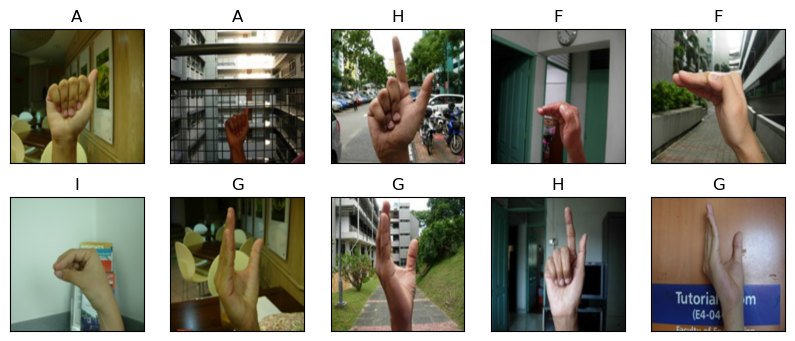

In [358]:
# Visualize some data
BG2_loader = load_dataset("/Users/marcia/Desktop/A2_middle/dataset", transformation)
images, labels = next(iter(BG2_loader))
images.shape
images = images.numpy() # convert images to numpy for display
classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(10, 4))
for idx in np.arange(10):
    ax = fig.add_subplot(2, 5, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

#### Without transfer learning

In [272]:
# Running best model from part3 on new dataset. The file 'dataset ' is the dataset with background
best_model = GestureCNN2()
best_path = 'GestureCNN2_bs64_lr0.008_epoch29.pth'
best_model.load_state_dict(torch.load(best_path))
if torch.cuda.is_available():
    best_model.cuda()
new_loader = load_dataset('/Users/marcia/Desktop/A2_middle/dataset', transformation, bs=64)
accuracy_new_p3 = get_accuracy(best_model, new_loader)
print(f"Accuracy on New dataset for 'GestureCNN2_bs64_lr0.008_epoch29' is: {accuracy_new_p3:.2%}")

Accuracy on New dataset for 'GestureCNN2_bs64_lr0.008_epoch29' is: 11.06%


#### With transfer learning

In [273]:
# load the test data
bg_loader = load_dataset("/Users/marcia/Desktop/A2_middle/dataset", transformation, bs=1)
bg_features, bg_labels = compute_alexnet_features(bg_loader)
print(f"New features: {bg_features.shape}, New labels: {bg_labels.shape}")
torch.save(bg_features, 'bg_features.pt')
torch.save(bg_labels, 'bg_labels.pt')

New features: torch.Size([1800, 256, 6, 6]), New labels: torch.Size([1800])


In [274]:
# Runing best model from part 4 on new dataset
# Load precomputed features and convert them
bg_features = torch.from_numpy(torch.load('bg_features.pt').detach().numpy())
bg_labels = torch.from_numpy(torch.load('bg_labels.pt').detach().numpy())

# Create TensorDatasets and Loader
new_dataset = TensorDataset(bg_features, bg_labels)
new_loader = DataLoader(new_dataset, batch_size=1)

# run best model on new dataset
best_model = Classifier_CNN()
best_path = 'Classifier_CNN_bs256_lr0.005_epoch19.pth'
best_model.load_state_dict(torch.load(best_path))
if torch.cuda.is_available():
    best_model.cuda()
accuracy_new_p4 = get_accuracy(best_model, new_loader)
print(f"Accuracy on New Dataset for 'Classifier_CNN_bs256_lr0.005_epoch19' Model is: {accuracy_new_p4:.2%}")

Accuracy on New Dataset for 'Classifier_CNN_bs256_lr0.005_epoch19' Model is: 14.50%


In [275]:
best_model_no_trans = accuracy_new_p3
best_model_yes_trans = accuracy_new_p4

# Create a pandas DataFrame
results_df = pd.DataFrame({
    'Model': ['GestureCNN2 (No Transfer learning)', 'Classifier_CNN (Transfer Learning)'],
    'New Dataset Accuracy': [best_model_no_trans, best_model_yes_trans]
})

results_df

,Model,New Dataset Accuracy
0,GestureCNN2 (No Transfer learning),0.110556
1,Classifier_CNN (Transfer Learning),0.145000


#### Comments:

- Overall Accuracy: Both models show relatively low accuracy scores (11.06% for the model without transfer learning and 14.5% for the model with transfer learning). This suggests that both models are struggling with the dataset, which could be due to the complexity introduced by the varied backgrounds. The low accuracy scores indicate that the models are not effectively generalizing to the new background conditions, which is likely due to the lack of exposure to such conditions during training.

- Impact of Transfer Learning: The model that utilized transfer learning (Classifier_CNN) performs slightly better than the one without transfer learning (GestureCNN2). This improvement, although modest, indicates that pre-trained features can provide an advantage, even when the background conditions change. This suggests that the pre-trained features are more robust and adaptable to new conditions, which is a key advantage of transfer learning.

- Challenges with Varied Backgrounds: The drop in accuracy compared to when the models were possibly trained on images with fixed backgrounds suggests that the introduction of varied textures and elements in the background has added a level of complexity that the models are not handling well. It could be the case that the features learned from the cleaner backgrounds do not generalize well to more complex backgrounds. This highlights the importance of training models on diverse datasets that reflect real-world conditions.

### Step 2: Generating additional data by performing data augmentation: 
output dataset name: images_BG

In [ ]:
from torchvision import models, transforms
import os
import torch
from torchvision import models, transforms
from PIL import Image
import numpy as np
import random

# Load the segmentation model
model = models.segmentation.deeplabv3_resnet101(pretrained=True)
model.eval()

# Prepare image transforms
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def segment_and_composite(input_image_path, background_image_path, output_image_path):
    # Load and preprocess the input image
    input_image = Image.open(input_image_path).convert("RGB")
    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0)

    # Perform segmentation
    with torch.no_grad():
        output = model(input_batch)['out'][0]
    output_predictions = output.argmax(0)
    hand_mask = output_predictions == 15  # Assuming '15' is the class for hands

    # Convert segmentation mask to PIL Image (single-channel)
    hand_mask = hand_mask.to(torch.uint8) * 255  # Convert boolean mask to uint8
    hand_mask_pil = transforms.ToPILImage()(hand_mask)  # Convert to PIL Image
    hand_mask_pil = hand_mask_pil.resize(input_image.size, Image.NEAREST)  # Resize mask to match input_image

    # Load and resize background image to match input_image size
    background = Image.open(background_image_path).convert("RGB").resize(input_image.size)

    # Composite the hand onto the new background using the mask
    composite_image = Image.composite(input_image, background, hand_mask_pil.convert("L"))

    # Convert to RGB (if transparency is not needed) and save
    composite_image = composite_image.convert("RGB")
    composite_image.save(output_image_path)



# Paths
source_dir = '/Users/marcia/Desktop/A2_middle/1517hands'
backgrounds_dir = '/Users/marcia/Desktop/A2_middle/Backgrounds'
output_dir = '/Users/marcia/Desktop/A2_middle/images_BG'

# Load all background images into a list
background_images = [os.path.join(backgrounds_dir, f) for f in os.listdir(backgrounds_dir) if f.endswith(('jpg', 'png'))]

main_folders = ['train', 'val', 'test']

# Process each image in each subfolder
for main_folder in main_folders:
    for label in 'ABCDEFGHI':
        label_dir = os.path.join(source_dir, main_folder, label)
        output_label_dir = os.path.join(output_dir, main_folder, label)
        os.makedirs(output_label_dir, exist_ok=True)
        
        for image_name in os.listdir(label_dir):
            if image_name.endswith(('jpg', 'png')):
                input_image_path = os.path.join(label_dir, image_name)
                output_image_path = os.path.join(output_label_dir, image_name)
                background_image_path = random.choice(background_images)  # Randomly select a background
                
                segment_and_composite(input_image_path, background_image_path, output_image_path)

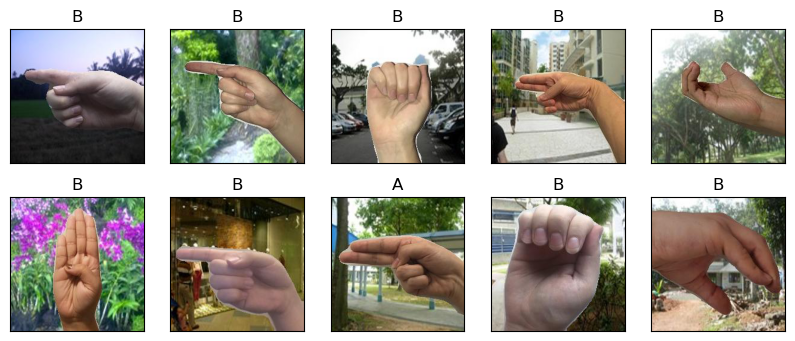

In [344]:
# Visualize some data
first_AUG_loader = load_dataset("/Users/marcia/Desktop/A2_middle/images_BG", transformation)
images, labels = next(iter(first_AUG_loader))
images.shape
images = images.numpy() # convert images to numpy for display
classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(10, 4))
for idx in np.arange(10):
    ax = fig.add_subplot(2, 5, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

### Step 3: Improve on  data augmentation: 
output dataset name: images_improved

In [277]:
def apply_transformations(image, mask, max_rotation=30, max_translate=(50, 50), min_scale=0.8, max_scale=1.2):
    """Apply random scale, rotation, and translation transformations."""
    # Random rotation
    angle = random.uniform(-max_rotation, max_rotation)
    image = TF.rotate(image, angle)
    mask = TF.rotate(mask, angle)

    # Random translation (shift)
    translate = (random.uniform(-max_translate[0], max_translate[0]),
                 random.uniform(-max_translate[1], max_translate[1]))
    image = TF.affine(image, angle=0, translate=translate, scale=1.0, shear=0)
    mask = TF.affine(mask, angle=0, translate=translate, scale=1.0, shear=0)

    # Random scale
    scale = random.uniform(min_scale, max_scale)
    width, height = image.size
    new_width, new_height = int(width * scale), int(height * scale)
    image = TF.resize(image, (new_height, new_width))
    mask = TF.resize(mask, (new_height, new_width), interpolation=Image.NEAREST)

    return image, mask

In [ ]:
def segment_and_composite(input_image_path, background_image_path, output_image_path):
    # Load and preprocess the input image
    input_image = Image.open(input_image_path).convert("RGB")
    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0)

    # Perform segmentation
    with torch.no_grad():
        output = model(input_batch)['out'][0]
    output_predictions = output.argmax(0)
    hand_mask = output_predictions == 15  # Assuming '15' is the class for hands

    # Convert segmentation mask to PIL Image (single-channel)
    hand_mask = hand_mask.to(torch.uint8) * 255  # Convert boolean mask to uint8
    hand_mask_pil = transforms.ToPILImage()(hand_mask)  # Convert to PIL Image
    hand_mask_pil = hand_mask_pil.resize(input_image.size, Image.NEAREST)  # Resize mask to match input_image

    # Apply transformations to both input_image and hand_mask_pil
    transformed_input_image, transformed_hand_mask_pil = apply_transformations(
        input_image, hand_mask_pil.convert("L"), max_rotation=30, max_translate=(50, 50), min_scale=0.8, max_scale=1.2)
    
    # Ensure the background is resized to match the transformed image size
    background = Image.open(background_image_path).convert("RGB")
    background = background.resize(transformed_input_image.size)

    # Now composite the transformed hand onto the resized new background
    composite_image = Image.composite(transformed_input_image, background, transformed_hand_mask_pil)

    # Convert to and save
    composite_image = composite_image.convert("RGB")
    composite_image.save(output_image_path)



# Paths
source_dir = '/Users/marcia/Desktop/A2_middle/1517hands'
backgrounds_dir = '/Users/marcia/Desktop/A2_middle/Backgrounds'
output_dir = '/Users/marcia/Desktop/A2_middle/images_BG_improved'

# Load all background images into a list
background_images = [os.path.join(backgrounds_dir, f) for f in os.listdir(backgrounds_dir) if f.endswith(('jpg', 'png'))]

# Process each image in each subfolder
main_folders = ['train', 'val', 'test']
# Process each image in each subfolder
for main_folder in main_folders:
    for label in 'ABCDEFGHI':
        label_dir = os.path.join(source_dir, main_folder, label)
        output_label_dir = os.path.join(output_dir, main_folder, label)
        os.makedirs(output_label_dir, exist_ok=True)
        
        for image_name in os.listdir(label_dir):
            if image_name.endswith(('jpg', 'png')):
                input_image_path = os.path.join(label_dir, image_name)
                output_image_path = os.path.join(output_label_dir, image_name)
                background_image_path = random.choice(background_images)  # Randomly select a background
                
                segment_and_composite(input_image_path, background_image_path, output_image_path)


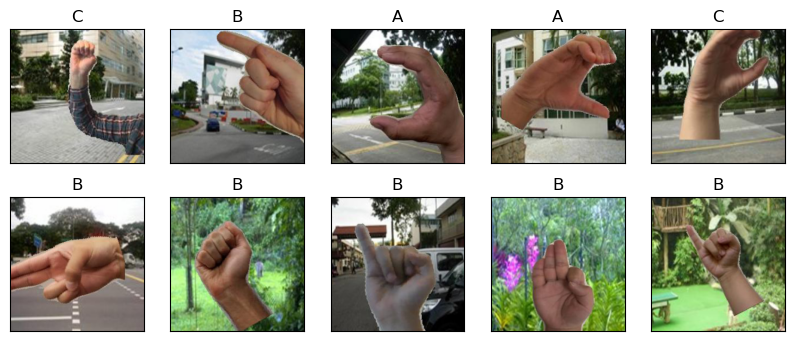

In [356]:
# Visualize some data
second_AUG_loader = load_dataset("/Users/marcia/Desktop/A2_middle/images_BG_improved", transformation)
images, labels = next(iter(second_AUG_loader))
images.shape
images = images.numpy() # convert images to numpy for display
classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(10, 4))
for idx in np.arange(10):
    ax = fig.add_subplot(2, 5, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

### Step 4: compare CNN models (with and without transfer learning)

#### Train best model without transfer learning on images_BG_improved

Total 30 epochs, lr = 0.008, bs = 64.
Start training GestureCNN2 model...
Epoch 0: Average Train Loss: 2.2009, Train Accuracy: 11.20%, Validation Accuracy: 11.22%
Epoch 4: Average Train Loss: 2.1979, Train Accuracy: 11.20%, Validation Accuracy: 11.22%
Epoch 8: Average Train Loss: 2.1976, Train Accuracy: 11.20%, Validation Accuracy: 11.22%
Epoch 12: Average Train Loss: 2.1990, Train Accuracy: 11.20%, Validation Accuracy: 11.22%
Epoch 16: Average Train Loss: 2.1981, Train Accuracy: 11.20%, Validation Accuracy: 11.22%
Epoch 20: Average Train Loss: 2.1982, Train Accuracy: 11.32%, Validation Accuracy: 12.22%
Epoch 24: Average Train Loss: 2.1979, Train Accuracy: 11.20%, Validation Accuracy: 11.22%
Epoch 28: Average Train Loss: 2.1974, Train Accuracy: 11.20%, Validation Accuracy: 11.22%
Epoch 29: Average Train Loss: 2.1969, Train Accuracy: 11.38%, Validation Accuracy: 10.22%
Finished Training in 629.05 seconds


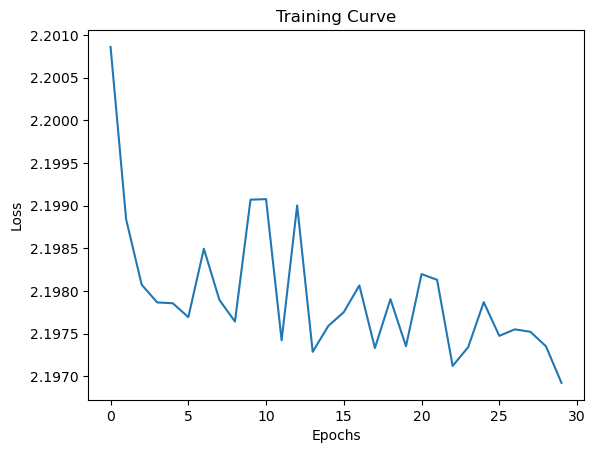

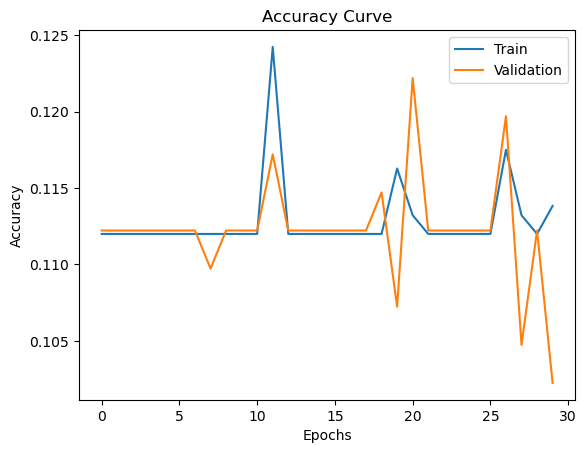

Final Training Accuracy: 11.38%
Final Validation Accuracy: 10.22%


In [305]:
# The previous best mode with batch size 64, learning rate 0.008
cnn2_model = GestureCNN2()
train_loader = load_dataset('/Users/marcia/Desktop/A2_middle/images_BG_improved/train', transformation, bs=64)
val_loader = load_dataset('/Users/marcia/Desktop/A2_middle/images_BG_improved/val', transformation, bs=64)
os.chdir('/Users/marcia/Desktop/A2_middle/model_augmented')
train(cnn2_model, train_loader, val_loader, num_epochs=30, learning_rate=0.008, batch_size=64)

##### Test on test folder

In [338]:
# Running best model from part3 on new dataset. The file 'dataset ' is the dataset with background
best_model = GestureCNN2()
best_path = '/Users/marcia/Desktop/A2_middle/model_augmented/GestureCNN2_bs64_lr0.008_epoch20.pth' # choose the best model path, should be in model_augmented, if no, please create one
best_model.load_state_dict(torch.load(best_path))
if torch.cuda.is_available():
    best_model.cuda()
new_loader = load_dataset('/Users/marcia/Desktop/A2_middle/images_BG_improved/test', transformation, bs=128)
accuracy_new_p3_abc = get_accuracy(best_model, new_loader)
print(f"Accuracy on New dataset for 'best_modelname' is: {accuracy_new_p3_abc:.2%}")

Accuracy on New dataset for 'best_modelname' is: 11.62%


#### Train best model with transfer learning on images_BG_improved

In [307]:
train_loader = load_dataset('/Users/marcia/Desktop/A2_middle/images_BG_improved/train', transformation, bs=1)
val_loader = load_dataset('/Users/marcia/Desktop/A2_middle/images_BG_improved/val', transformation, bs=1)
test_loader = load_dataset('/Users/marcia/Desktop/A2_middle/images_BG_improved/test', transformation, bs=1)

train_features, train_labels = compute_alexnet_features(train_loader)
val_features, val_labels = compute_alexnet_features(val_loader)
test_features, test_labels = compute_alexnet_features(test_loader)

print(train_features.size(), train_labels.size())
print(val_features.size(), val_labels.size())
print(test_features.size(), test_labels.size())

os.chdir('/Users/marcia/Desktop/A2_middle/model_augmented')
# Save features
print('Saving features and labels....')
torch.save(train_features, 'BGtrain_features.pt')
torch.save(val_features, 'BGval_features.pt')
torch.save(test_features, 'BGtest_features.pt')
torch.save(train_labels, 'BGtrain_labels.pt')
torch.save(val_labels, 'BGval_labels.pt')
torch.save(test_labels, 'BGtest_labels.pt')
print('Done!')

torch.Size([1634, 256, 6, 6]) torch.Size([1634])
torch.Size([401, 256, 6, 6]) torch.Size([401])
torch.Size([396, 256, 6, 6]) torch.Size([396])
Saving features and labels....
Done!


Total 20 epochs, lr = 0.005, bs = 256.
Start training Classifier_CNN model...
Epoch 0: Train Loss: 2.2056, Train Acc: 17.01%, Val Acc: 16.71%


Epoch 1: Train Loss: 2.1532, Train Acc: 26.32%, Val Acc: 25.69%
Epoch 2: Train Loss: 2.0716, Train Acc: 33.60%, Val Acc: 37.41%
Epoch 3: Train Loss: 1.9173, Train Acc: 32.93%, Val Acc: 31.42%
Epoch 4: Train Loss: 1.7340, Train Acc: 49.82%, Val Acc: 43.14%
Epoch 5: Train Loss: 1.5011, Train Acc: 58.45%, Val Acc: 49.13%
Epoch 6: Train Loss: 1.2815, Train Acc: 63.10%, Val Acc: 50.62%
Epoch 7: Train Loss: 1.1729, Train Acc: 61.38%, Val Acc: 50.87%
Epoch 8: Train Loss: 1.0694, Train Acc: 64.63%, Val Acc: 53.37%
Epoch 9: Train Loss: 0.9816, Train Acc: 72.58%, Val Acc: 55.11%
Epoch 10: Train Loss: 0.8882, Train Acc: 72.64%, Val Acc: 57.36%
Epoch 11: Train Loss: 0.8268, Train Acc: 76.50%, Val Acc: 59.10%
Epoch 12: Train Loss: 0.7516, Train Acc: 77.17%, Val Acc: 60.60%
Epoch 13: Train Loss: 0.7152, Train Acc: 76.01%, Val Acc: 59.10%
Epoch 14: Train Loss: 0.7212, Train Acc: 80.05%, Val Acc: 59.10%
Epoch 15: Train Loss: 0.6241, Train Acc: 82.44%, Val Acc: 61.35%
Epoch 16: Train Loss: 0.5943, Trai

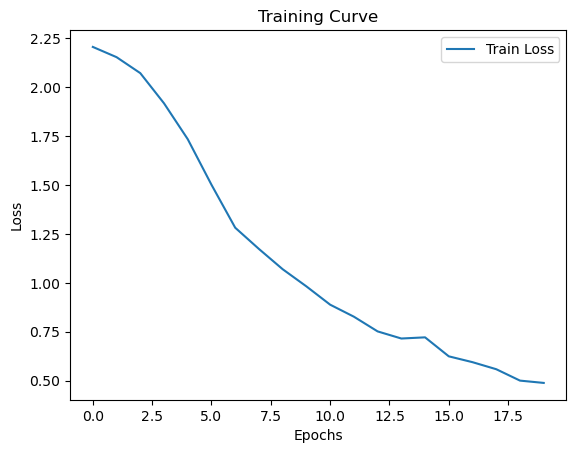

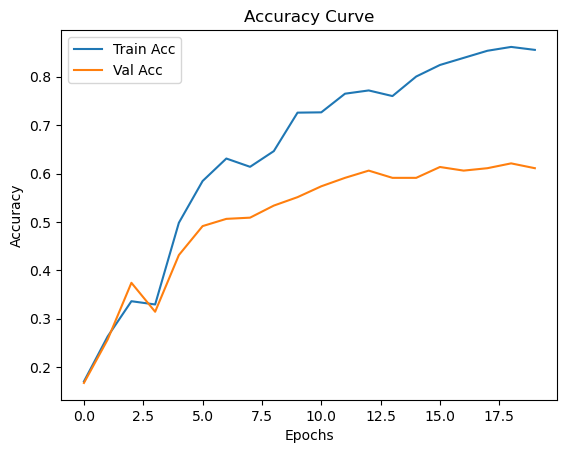

Final Training Accuracy: 85.56%
Final Validation Accuracy: 61.10%


In [321]:
# Load precomputed features and convert them
os.chdir('/Users/marcia/Desktop/A2_middle/model_augmented')
train_features = torch.from_numpy(torch.load('BGtrain_features.pt').detach().numpy())
val_features = torch.from_numpy(torch.load('BGval_features.pt').detach().numpy())
test_features = torch.from_numpy(torch.load('BGtest_features.pt').detach().numpy())

# Create TensorDatasets
train_dataset = TensorDataset(train_features, train_labels)
val_dataset = TensorDataset(val_features, val_labels)
test_dataset = TensorDataset(test_features, test_labels)

# Create DataLoaders
batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Initialize model and call the train function
model = Classifier_CNN()
os.chdir('/Users/marcia/Desktop/A2_middle/model_augmented')
train_feat(model, train_loader, val_loader, num_epochs=20, learning_rate=0.005, batch_size=256)

##### Test on Test folder

In [326]:
# Runing best model from part 4 on new dataset
# Load precomputed features and convert them

test_dataset = TensorDataset(test_features, test_labels)
test_loader = DataLoader(test_dataset, batch_size=256)

# run best model on new dataset
best_model = Classifier_CNN()
best_path = '/Users/marcia/Desktop/A2_middle/model_augmented/Classifier_CNN_bs256_lr0.005_epoch18.pth'# choose the best model path, should be in model_augmented
best_model.load_state_dict(torch.load(best_path))
if torch.cuda.is_available():
    best_model.cuda()
test_transfer = get_accuracy(best_model, test_loader)
print(f"Accuracy on New Dataset for 'Classifier_CNN_bs256_lr0.005_epoch18' Model is: {test_transfer:.2%}")

Accuracy on New Dataset for 'Classifier_CNN_bs256_lr0.005_epoch18' Model is: 62.37%


#### Compare the results

##### Without transfer learning

In [310]:
# Running best model from part3 on new dataset. The file 'dataset ' is the dataset with background
best_model = GestureCNN2()
best_path = '/Users/marcia/Desktop/A2_middle/model_augmented/GestureCNN2_bs64_lr0.008_epoch20.pth' # choose the best model path, should be in model_augmented, if no, please create one
best_model.load_state_dict(torch.load(best_path))
if torch.cuda.is_available():
    best_model.cuda()
new_loader = load_dataset('/Users/marcia/Desktop/A2_middle/dataset', transformation, bs=128)
accuracy_new_p3_abc = get_accuracy(best_model, new_loader)
print(f"Accuracy on New dataset for 'best_modelname' is: {accuracy_new_p3_abc:.2%}")

Accuracy on New dataset for 'best_modelname' is: 10.83%


##### With transfer learning

In [324]:
# Runing best model from part 4 on new dataset
# Load precomputed features and convert them
os.chdir('/Users/marcia/Desktop/A2_middle/')
bg_features = torch.from_numpy(torch.load('bg_features.pt').detach().numpy())
bg_labels = torch.from_numpy(torch.load('bg_labels.pt').detach().numpy())

# Create TensorDatasets and Loader
new_dataset = TensorDataset(bg_features, bg_labels)
new_loader = DataLoader(new_dataset, batch_size=1)

# run best model on new dataset
best_model = Classifier_CNN()
best_path = '/Users/marcia/Desktop/A2_middle/model_augmented/Classifier_CNN_bs256_lr0.005_epoch18.pth'# choose the best model path, should be in model_augmented
best_model.load_state_dict(torch.load(best_path))
if torch.cuda.is_available():
    best_model.cuda()
accuracy_new_p4_abc = get_accuracy(best_model, new_loader)
print(f"Accuracy on New Dataset for 'Classifier_CNN_bs256_lr0.005_epoch18' Model is: {accuracy_new_p4_abc:.2%}")

Accuracy on New Dataset for 'Classifier_CNN_bs256_lr0.005_epoch18' Model is: 16.78%


##### Final Table for 4 (a) and 4 (b) comparison

In [339]:


# Create a pandas DataFrame
results_df2 = pd.DataFrame({
    'Model': ['GestureCNN2 (No Transfer learning)',
              'GestureCNN2 with augumentaiton (No Transfer learning)',
              'Classifier_CNN (Transfer Learning)',
              'Classifier_CNN with augumentaiton (Transfer Learning)'],
    'background Dataset Accuracy': [0.1106,0.1083,0.1405,0.1678],

    'test folder accuracy':[0.7146,0.1162,0.9217,0.6237]


})

results_df2

,Model,background Dataset Accuracy,test folder accuracy
0,GestureCNN2 (No Transfer learning),0.1106,0.7146
1,GestureCNN2 with augumentaiton (No Transfer le...,0.1083,0.1162
2,Classifier_CNN (Transfer Learning),0.1405,0.9217
3,Classifier_CNN with augumentaiton (Transfer Le...,0.1678,0.6237


##### Comments:
The table illustrates the performance of two different CNN architectures on distinct hand gesture datasets. The GestureCNN2 model, which does not incorporate transfer learning, and the Classifier_CNN model, which does, were initially trained and tested on the "1517hands" dataset, a collection of hand gesture images set against a clean and smooth background.

The GestureCNN2 model achieves a test accuracy of 71.46% on the original "1517hands" dataset, while the Classifier_CNN model significantly outperforms it with a test accuracy of 92.17%. This stark contrast in performance could be attributed to the Classifier_CNN model's ability to leverage pre-trained features from AlexNet, which are especially effective against the dataset's uniform background.

Further experiments involve augmentation strategies to introduce more complexity into the dataset. The "images_BG" dataset was created by replacing the smooth background from "1517hands" with various other backdrops. Subsequently, the "images_BG_improved" dataset was generated by applying scaling, rotation, and translation transformations to the "images_BG" dataset.

The results show that both models with augmentation — GestureCNN2 with augmentation and Classifier_CNN with augmentation — experienced a drop in accuracy on the "images_BG_improved" dataset compared to the "1517hands" dataset. This suggests that the increased complexity and variability introduced by the background replacement and geometric transformations presented new challenges that the models were not initially trained to handle. Notably, the augmentation reduces the Classifier_CNN's accuracy from 92.17% to 62.37%, indicating that even with transfer learning, the model's robustness to background variation and geometric distortions is limited.

Future work to improve performance on augmented datasets:

1. Extended Augmentation in Training: 
    - Including a wider variety of backgrounds and transformations during the training phase to help the model better learn to generalize across diverse conditions.
    - Adding more data with more augumentaion, it will help model captures more feature of the images with complicated backgrounds or transformation, ultimately improving the prediction performance.

2. Fine-tuning on Augmented Data:
    - Further training (fine-tuning) the transfer learning model on the augmented dataset to adapt the pre-trained features to the new data characteristics.

3. Complexity Adjustment: 
    - For the GestureCNN2 model, increasing its complexity may help capture more abstract features that are invariant to the background and geometric changes.
    - The current model are fine-tuning on "1517hands" dataset which are images with clean and smooth background. It is necessary to fine-tuning the neural network model in order to capture more complicated images when considering to imrpove the model performance on images with augmentation.

4. Hyperparameter Optimization: 
    - Fine-tuning the learning rate, batch size, and other hyperparameters specific to training with augmented data.

These approaches aim to enhance the models' ability to cope with the added complexities of the augmented datasets and to maintain high accuracy levels when faced with real-world variability in hand gesture recognition tasks.

### Step 5: Implement one of many region proposal tools to detect hand gestures in image frames and put a bounding box around the region with the highest confidence.
Ouput folder: images_with_boxes

In [ ]:
import torchvision.models as models
import torchvision.transforms as T
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import ImageDraw

# Load a pre-trained YOLO model
model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()
# Output Cleared for better visualization

In [ ]:
def load_and_preprocess_image(image_path):
    img = Image.open(image_path).convert("RGB")
    img_tensor = preprocess(img)
    return img_tensor.unsqueeze(0)  # Add batch dimension


def detect_and_draw_boxes(model, image_tensor, original_image, output_path):
    with torch.no_grad():
        prediction = model(image_tensor)
    
    scores = prediction[0]['scores']
    
    # Check if there are any detections
    if len(scores) > 0:
        highest_confidence_index = scores.argmax()
        boxes = prediction[0]['boxes']
        box = boxes[highest_confidence_index].numpy()

        # Draw the bounding box
        draw_image = original_image.copy()
        draw = ImageDraw.Draw(draw_image)
        draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline='red', width=3)
    else:
        # If no detections, copy the original image
        draw_image = original_image.copy()
    
    # Save the image with the bounding box (if drawn) or as is (if no detections)
    draw_image.save(output_path)

In [ ]:
main_folders = ['train', 'val', 'test']
base_dir = '/Users/marcia/Desktop/A2_middle/images_BG_improved'
output_base_dir = '/Users/marcia/Desktop/A2_middle/images_with_boxes'  # Define output base directory


for main_folder in main_folders:
    for gesture_label in 'ABCDEFGHI':
        label_dir = os.path.join(base_dir, main_folder, gesture_label)
        output_label_dir = os.path.join(output_base_dir, main_folder, gesture_label)
        os.makedirs(output_label_dir, exist_ok=True)  # Make sure the output directory exists
        
        for image_name in os.listdir(label_dir):
            if image_name.endswith(('jpg', 'png')):
                input_image_path = os.path.join(label_dir, image_name)
                output_image_path = os.path.join(output_label_dir, image_name)
                background_image_path = random.choice(background_images)  # Randomly select a background
                
                # Load and preprocess the image
                img_tensor = load_and_preprocess_image(input_image_path)
                original_img = Image.open(input_image_path)
                
                # Call the modified function with the output path
                detect_and_draw_boxes(model, img_tensor, original_img, output_image_path)

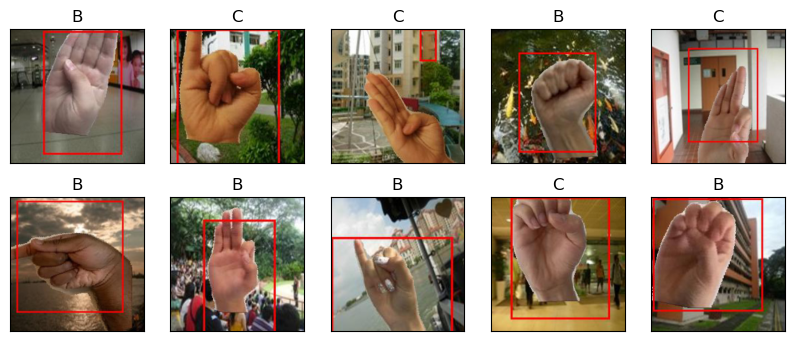

In [343]:
# Visualize some data
box_loader = load_dataset("/Users/marcia/Desktop/A2_middle/images_with_boxes", transformation)
images, labels = next(iter(box_loader))
images.shape
images = images.numpy() # convert images to numpy for display
classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(10, 4))
for idx in np.arange(10):
    ax = fig.add_subplot(2, 5, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

### Step 6: Use hand gesture model to communicate

In [399]:
from PIL import Image
gesture_mappings = {
    0: "A",
    1: "B",
    2: "C",
    3: "D",
    4: "E",
    5: "F",
    6: "G",
    7: "H",
    8: "I"
}

# Example preprocessing function
def preprocess_image(image_path):
    # Adjust the transformations to match model's training preprocessing
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0)  # Add a batch dimension
    return image

def predict_gesture(image):
    with torch.no_grad():  # Inference without tracking gradients
        output = model(image)
        _, predicted = torch.max(output.data, 1)
        return gesture_mappings[predicted.item()]
    
def show_images(image_paths):
    """Displays images in a grid."""
    fig, axes = plt.subplots(1, 4, figsize=(8,8)) 
    axes = axes.flatten()  # Flatten the 2D array of axes for easy iteration

    for ax, img_path in zip(axes, image_paths):
        image = Image.open(img_path)
        ax.imshow(image)
        ax.axis('off') 
        predicted_gesture = predict_gesture(preprocess_image(img_path))
        ax.set_title(f"Predicted: {predicted_gesture}")
    
    plt.tight_layout()
    plt.show()

In [400]:
model = GestureCNN2()
model.load_state_dict(torch.load('GestureCNN2_bs64_lr0.008_epoch29.pth'))
model.eval()

GestureCNN2(
  (conv1): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 15, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(15, 20, kernel_size=(1, 1), stride=(1, 1))
  (fc1): Linear(in_features=14580, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=9, bias=True)
)

Decoded Message: CAGE


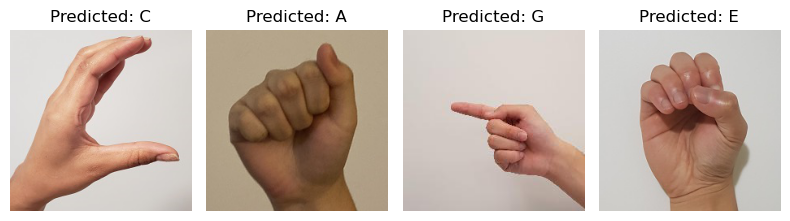

In [401]:
# image sequence
image_sequence = ['/Users/marcia/Desktop/A2_middle/1517hands/C/10_C_9.jpg',
                  '/Users/marcia/Desktop/A2_middle/1517hands/A/40_A_3.jpg', 
                  '/Users/marcia/Desktop/A2_middle/1517hands/G/6_G_1.jpg', 
                  '/Users/marcia/Desktop/A2_middle/1517hands/E/19_E_2.jpg']

# Decoding the message is separate since we're focusing on displaying the grid here
message = ''.join(predict_gesture(preprocess_image(img)) for img in image_sequence)
print("Decoded Message:", message)

# Show the images and predictions in a grid
show_images(image_sequence)




#### Comment:
In a real-world scenario, We could use a camera to take live images of hand gestures and feed them into system, which would predict and display the message in real-time. For example, using a gesture sequence could communicate a distress signal "SOS" (represented as "ESE" with available letters) or any other predefined message. This setup could be particularly useful in situations where verbal communication isn't possible or for accessibility applications such as sign language translation.

**Link to the video**

https://drive.google.com/file/d/1480E4Ww4r0pv8J6O1LmDFU1vorwSfGs-/view?usp=sharing
